**IMPORTING LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge,Lasso,LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
weather = pd.read_csv("Weather_Jodhpur.csv", index_col="DATE")

In [3]:
weather

,tavg,tmin,tmax,prcp
DATE,,,,
01-01-1990,22.9,19.1,28.4,NaN
02-01-1990,21.7,NaN,26.5,0.0
03-01-1990,21.0,16.4,26.5,0.0
04-01-1990,20.8,NaN,27.4,0.0
05-01-1990,20.4,14.2,26.1,0.0
...,...,...,...,...
21-07-2022,23.7,20.5,30.8,82.5
22-07-2022,23.2,21.1,27.9,0.0
23-07-2022,23.1,20.9,26.7,0.0


**CLEANING AND FILLING MISSING DATA**

In [4]:
#Filling missing values in each column with mode because the data we are having is a skewed data

weather['tavg'] = weather['tavg'].fillna(weather['tavg'].mode()[0])
weather['tmax'] = weather['tmax'].fillna(weather['tmax'].mode()[0])
weather['tmin'] = weather['tmin'].fillna(weather['tmin'].mode()[0])
weather['prcp'] = weather['prcp'].fillna(weather['prcp'].mode()[0])

In [5]:
weather

,tavg,tmin,tmax,prcp
DATE,,,,
01-01-1990,22.9,19.1,28.4,0.0
02-01-1990,21.7,20.0,26.5,0.0
03-01-1990,21.0,16.4,26.5,0.0
04-01-1990,20.8,20.0,27.4,0.0
05-01-1990,20.4,14.2,26.1,0.0
...,...,...,...,...
21-07-2022,23.7,20.5,30.8,82.5
22-07-2022,23.2,21.1,27.9,0.0
23-07-2022,23.1,20.9,26.7,0.0


In [6]:
weather.dtypes

tavg    float64
tmin    float64
tmax    float64
prcp    float64
dtype: object

In [7]:
weather.index

Index(['01-01-1990', '02-01-1990', '03-01-1990', '04-01-1990', '05-01-1990',
       '06-01-1990', '07-01-1990', '08-01-1990', '09-01-1990', '10-01-1990',
       ...
       '16-07-2022', '17-07-2022', '18-07-2022', '19-07-2022', '20-07-2022',
       '21-07-2022', '22-07-2022', '23-07-2022', '24-07-2022', '25-07-2022'],
      dtype='object', name='DATE', length=11894)

In [8]:
weather.index=pd.to_datetime(weather.index)

In [9]:
weather.index #Converting datatype from index to datetime format

DatetimeIndex(['1990-01-01', '1990-02-01', '1990-03-01', '1990-04-01',
               '1990-05-01', '1990-06-01', '1990-07-01', '1990-08-01',
               '1990-09-01', '1990-10-01',
               ...
               '2022-07-16', '2022-07-17', '2022-07-18', '2022-07-19',
               '2022-07-20', '2022-07-21', '2022-07-22', '2022-07-23',
               '2022-07-24', '2022-07-25'],
              dtype='datetime64[ns]', name='DATE', length=11894, freq=None)

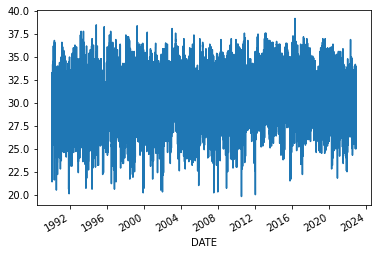

In [10]:
weather["tmax"].plot()

OUR ALGORITHM IS TO FIND TOMORROW'S TEMPERATURE. SO WE ADD TARGET COLUMN WHICH HAS TOMORROWS TEMPERATURE FOR EACH DAY AS THE TARGET VALUE

In [11]:
weather["target"] = weather.shift(-1)["tmax"]

In [12]:
weather

,tavg,tmin,tmax,prcp,target
DATE,,,,,
1990-01-01,22.9,19.1,28.4,0.0,26.5
1990-02-01,21.7,20.0,26.5,0.0,26.5
1990-03-01,21.0,16.4,26.5,0.0,27.4
1990-04-01,20.8,20.0,27.4,0.0,26.1
1990-05-01,20.4,14.2,26.1,0.0,24.2
...,...,...,...,...,...
2022-07-21,23.7,20.5,30.8,82.5,27.9
2022-07-22,23.2,21.1,27.9,0.0,26.7
2022-07-23,23.1,20.9,26.7,0.0,26.7


In [13]:
weather.drop(weather.tail(1).index,inplace = True) #Since for the last day we dont have future value we remove that row

Now lets check correlation between all these factors

In [14]:
weather.corr()

,tavg,tmin,tmax,prcp,target
tavg,1.000000,0.684337,0.852836,-0.054984,0.808018
tmin,0.684337,1.000000,0.411282,0.038095,0.394924
tmax,0.852836,0.411282,1.000000,-0.090166,0.843692
prcp,-0.054984,0.038095,-0.090166,1.000000,-0.079483
target,0.808018,0.394924,0.843692,-0.079483,1.000000


In [15]:
predictors = weather.columns[~weather.columns.isin(["target"])]

In [16]:
predictors

Index(['tavg', 'tmin', 'tmax', 'prcp'], dtype='object')

We are trying to predict the values. But inorder to estimate the error of this machine learning model. We need to use techniques like cross validation. But since our data is time series data. It is better to use backtesting 

In [17]:
def backtest(weather, model, predictors, start=3650, step=90):
    all_predictions = []

#It is just like sliding window algorithm type
    for i in range(start, weather.shape[0], step):
        train = weather.iloc[:i,:]
        test = weather.iloc[i:(i+step),:]
        
        model.fit(train[predictors], train["target"])
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test["target"], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()
        
        all_predictions.append(combined)
    return pd.concat(all_predictions)

In [18]:
target_arr = np.array(weather.target[3650:])

**LINEAR REGRESSION** 

In [19]:
lin = LinearRegression()

In [20]:
predictions_lin = backtest(weather, lin, predictors)

In [21]:
predictions_lin

,actual,prediction,diff
DATE,,,
1999-12-30,24.7,25.994307,1.294307
1999-12-31,26.1,25.268595,0.831405
2000-01-01,28.0,25.262888,2.737112
2000-02-01,25.8,26.900862,1.100862
2000-03-01,28.0,25.877593,2.122407
...,...,...,...
2022-07-20,30.8,30.902793,0.102793
2022-07-21,27.9,29.941278,2.041278
2022-07-22,26.7,28.210898,1.510898


In [22]:
predict_lin = np.array(predictions_lin["prediction"])

**Result: Linear Regression**

In [23]:
mean_absolute_error(target_arr,predict_lin)

0.9616969559830235

THAT MEANS ON AVG WE ARE 0.96 DEG OFF FROM ACTUAL AVG TEMPERATURE WHILE USING RIDGE MODEL TO PREDICT THE FUTURE TEMPERATURES

In [24]:
print(r2_score(target_arr,predict_lin))

0.795346854741531


Plotting the graph

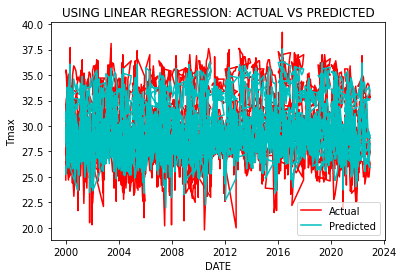

In [25]:
plt.plot(np.array(predictions_lin.index), target_arr, color='r', label='Actual')
plt.plot(np.array(predictions_lin.index), predict_lin, color = 'c', label='Predicted')
  
plt.xlabel("DATE")
plt.ylabel("Tmax")
plt.title("USING LINEAR REGRESSION: ACTUAL VS PREDICTED")
  
plt.legend()
  
plt.show()

**RIDGE REGRESSION**

In [26]:
ridg = Ridge()

In [27]:
predictions_ridg = backtest(weather, ridg, predictors)
predictions_ridg

,actual,prediction,diff
DATE,,,
1999-12-30,24.7,25.994280,1.294280
1999-12-31,26.1,25.268617,0.831383
2000-01-01,28.0,25.263308,2.736692
2000-02-01,25.8,26.900987,1.100987
2000-03-01,28.0,25.877856,2.122144
...,...,...,...
2022-07-20,30.8,30.902769,0.102769
2022-07-21,27.9,29.941309,2.041309
2022-07-22,26.7,28.210937,1.510937


In [28]:
predict_ridg = np.array(predictions_ridg["prediction"])

**Result: Ridge Regression**

In [29]:
mean_absolute_error(target_arr,predict_ridg)

0.9617012598885474

In [30]:
print(r2_score(target_arr,predict_ridg))

0.7953452219779952


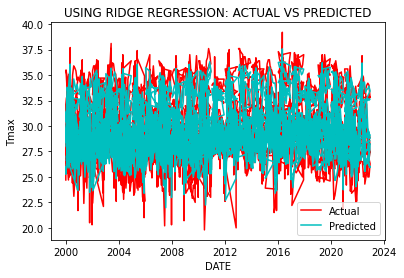

In [31]:
plt.plot(np.array(predictions_ridg.index), target_arr, color='r', label='Actual')
plt.plot(np.array(predictions_ridg.index), predict_ridg, color = 'c', label='Predicted')
  
plt.xlabel("DATE")
plt.ylabel("Tmax")
plt.title("USING RIDGE REGRESSION: ACTUAL VS PREDICTED")
  
plt.legend()
  
plt.show()

**LASSO REGRESSION** 

In [32]:
lass = Lasso()

In [33]:
predictions_lass = backtest(weather, lass, predictors)

In [34]:
predictions_lass

,actual,prediction,diff
DATE,,,
1999-12-30,24.7,26.373148,1.673148
1999-12-31,26.1,25.837907,0.262093
2000-01-01,28.0,26.587640,1.412360
2000-02-01,25.8,27.504463,1.704463
2000-03-01,28.0,26.804501,1.195499
...,...,...,...
2022-07-20,30.8,30.612914,0.187086
2022-07-21,27.9,30.388250,2.488250
2022-07-22,26.7,28.557055,1.857055


In [35]:
predict_lass = np.array(predictions_lass["prediction"])

**Result: Lasso Regression**

In [36]:
mean_absolute_error(target_arr,predict_lass)

1.0944655967444152

THAT MEANS ON AVG WE ARE 1.09 DEG OFF FROM ACTUAL AVG TEMPERATURE WHILE USING RIDGE MODEL TO PREDICT THE FUTURE TEMPERATURES

In [37]:
print(r2_score(target_arr,predict_lass))

0.7498375111158879


Plotting the graph

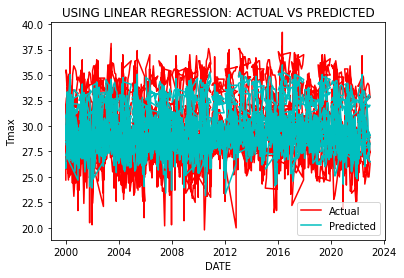

In [38]:
plt.plot(np.array(predictions_lass.index), target_arr, color='r', label='Actual')
plt.plot(np.array(predictions_lass.index), predict_lass, color = 'c', label='Predicted')
  
plt.xlabel("DATE")
plt.ylabel("Tmax")
plt.title("USING LINEAR REGRESSION: ACTUAL VS PREDICTED")
  
plt.legend()
  
plt.show()